In [45]:
import numpy as np
import math
from scipy.spatial import distance_matrix
import stan
import matplotlib.pyplot as plt

import nest_asyncio
nest_asyncio.apply()
del nest_asyncio

In [7]:
n = 100
np.random.seed(400)
n_pairs = math.comb(n, 2)
# TODO: generalize to multiple covariates
locs  = np.random.uniform(-1, 1, 2*n).reshape(n, 2)
distances = distance_matrix(locs, locs)

In [8]:
# paired features
x1 = np.random.normal(size = n)
x2 = np.random.normal(size = n)
# first column is intercept term
x = np.ones((n_pairs, 2))
counter = 0
for i in range(n - 1):
    for j in range(i+1, n):
        x[counter, 1] = abs(x1[i] - x2[j])
        counter += 1

In [9]:
# individual features
z0 = np.random.normal(size=(n, 2))
z = np.zeros((n_pairs,2))
counter = 0
for i in range(n-1):
    for j in range(i+1, n):
        z[counter] = z0[i] + z0[j]
        counter += 1

In [10]:
# pairs matrix
counter = 0
w = np.zeros((n_pairs, n))
for i in range(n-1):
    for j in range(i+1, n):
        w[counter, i] = 1
        w[counter, j] = 1
        counter = counter + 1

In [13]:
# pair coefficients
beta = np.array([1, -0.3])
# individual covariates
gamma = np.array([2.1, -1.75])
# noise variance
sigma2_eps = 0.1
# baseline spatial variance
tau2 = 2
# individual-effect variance
sigma2_zeta = 0.01

# exponential kernel scale
ell = 0.2
# kernel matrix
K = tau2 * np.exp(-distances / ell)
# spatial factor of GP
eta = np.random.multivariate_normal(np.zeros(n), K)
# incorporate individual effects
theta = eta + np.random.normal(0, np.sqrt(sigma2_zeta), n)
# mean centering
theta = theta - theta.mean()
# mean function
mu = np.dot(x, beta) + np.dot(z, gamma) + np.dot(w, theta)


In [14]:
# log patristic distances
y = np.random.normal(loc=mu, scale=np.sqrt(sigma2_eps))

In [15]:
data = {
    "N": n,
    "M": n_pairs,
    "P": 2,
    "Q": 2,
    "y": y,
    "X": x,
    "Z": z,
    "W": w,
    "S": distances
}

In [16]:
with open("../models/patristic_distance.stan", "r") as file:
    model_code = file.read()

In [17]:
posterior = stan.build(model_code, data=data, random_seed=1)

Building...

In file included from /Users/pchatha/Library/Caches/httpstan/4.10.1/models/elwyfz3i/model_elwyfz3i.cpp:2:
In file included from /Users/pchatha/epi/gene-pairs/.venv/lib/python3.11/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/pchatha/epi/gene-pairs/.venv/lib/python3.11/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/pchatha/epi/gene-pairs/.venv/lib/python3.11/site-packages/httpstan/include/stan/math/rev.hpp:4:
In file included from /Users/pchatha/epi/gene-pairs/.venv/lib/python3.11/site-packages/httpstan/include/stan/math/prim/fun/Eigen.hpp:23:
In file included from /Users/pchatha/epi/gene-pairs/.venv/lib/python3.11/site-packages/httpstan/include/Eigen/Sparse:26:
In file included from /Users/pchatha/epi/gene-pairs/.venv/lib/python3.11/site-packages/httpstan/include/Eigen/SparseCore:61:
/Users/pchatha/epi/gene-pairs/.venv/lib/python3.11/site-packages/httpstan/include/Eigen/src/SparseCore/TriangularSolver.h:273:13:

ld: warning: object file (/Users/pchatha/epi/gene-pairs/.venv/lib/python3.11/site-packages/httpstan/stan_services.o) was built for newer macOS version (11.0) than being linked (10.9)
ld: warning: dylib (/Users/pchatha/epi/gene-pairs/.venv/lib/python3.11/site-packages/httpstan/lib/libtbbmalloc_proxy.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: dylib (/Users/pchatha/epi/gene-pairs/.venv/lib/python3.11/site-packages/httpstan/lib/libtbb.dylib) was built for newer macOS version (10.11) than being linked (10.9)ld: warning: dylib (/Users/pchatha/epi/gene-pairs/.venv/lib/python3.11/site-packages/httpstan/lib/libtbbmalloc.dylib) was built for newer macOS version (10.11) than being linked (10.9)

ld: warning: object file (/Users/pchatha/epi/gene-pairs/.venv/lib/python3.11/site-packages/httpstan/lib/libsundials_nvecserial.a(nvector_serial.o)) was built for newer macOS version (11.0) than being linked (10.9)
ld: warning: object file (/Users/pchatha/epi/gen

In [18]:
fit = posterior.sample(num_chains=1, num_samples=200)

Sampling:   0%
Sampling:   0% (1/1200)
Sampling:   8% (100/1200)
Sampling:  17% (200/1200)
Sampling:  25% (300/1200)
Sampling:  33% (400/1200)
Sampling:  42% (500/1200)
Sampling:  50% (600/1200)
Sampling:  58% (700/1200)
Sampling:  67% (800/1200)
Sampling:  75% (900/1200)
Sampling:  83% (1000/1200)
Sampling:  83% (1001/1200)
Sampling:  92% (1100/1200)
Sampling: 100% (1200/1200)
Sampling: 100% (1200/1200), done.
Messages received during sampling:
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: cholesky_decompose: Matrix m is not positive definite (in '/var/folders/9p/377m_bps09g843k84xfxg6nr0000gr/T/httpstan_pu9wp0ei/model_elwyfz3i.stan', line 50, column 4 to column 32)
  Gradient evaluation took 0.002445 seconds
  1000 transitions using 10 leapfrog steps per transition would take 24.45 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the fol

In [19]:
fit["gamma"][-20:].mean(1)

array([ 2.19087883, -1.83077038])

In [20]:
fit["beta"][-20:].mean(1)

array([ 1.03898042, -0.29747867])

In [43]:
theta.mean()

2.886579864025407e-17

In [49]:
theta_guess = fit["zeta"][:, -10:].mean(1) + fit["eta"][:, -10:].mean(1)

In [53]:
np.arange(-4, 4, 0.1)

array([-4.00000000e+00, -3.90000000e+00, -3.80000000e+00, -3.70000000e+00,
       -3.60000000e+00, -3.50000000e+00, -3.40000000e+00, -3.30000000e+00,
       -3.20000000e+00, -3.10000000e+00, -3.00000000e+00, -2.90000000e+00,
       -2.80000000e+00, -2.70000000e+00, -2.60000000e+00, -2.50000000e+00,
       -2.40000000e+00, -2.30000000e+00, -2.20000000e+00, -2.10000000e+00,
       -2.00000000e+00, -1.90000000e+00, -1.80000000e+00, -1.70000000e+00,
       -1.60000000e+00, -1.50000000e+00, -1.40000000e+00, -1.30000000e+00,
       -1.20000000e+00, -1.10000000e+00, -1.00000000e+00, -9.00000000e-01,
       -8.00000000e-01, -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
       -4.00000000e-01, -3.00000000e-01, -2.00000000e-01, -1.00000000e-01,
        3.55271368e-15,  1.00000000e-01,  2.00000000e-01,  3.00000000e-01,
        4.00000000e-01,  5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
        8.00000000e-01,  9.00000000e-01,  1.00000000e+00,  1.10000000e+00,
        1.20000000e+00,  

Text(0, 0.5, 'True Theta')

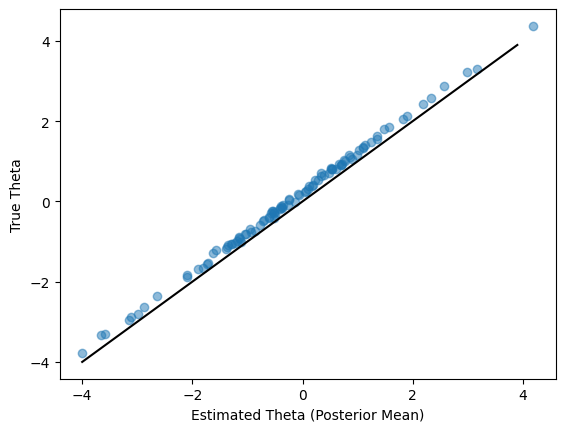

In [57]:
plt.scatter(theta_guess, theta, alpha=0.5)
plt.plot(np.arange(-4, 4, 0.1), np.arange(-4, 4, 0.1), color="k")
plt.xlabel("Estimated Theta (Posterior Mean)")
plt.ylabel("True Theta")
